In [2]:
import datasets
import pandas as pd
human_data = datasets.load_dataset('boda/review_evaluation_human_annotation', name = 'combined_main_aspects', split = 'full').to_pandas()


# # Load the test and train splits
# test_data = datasets.load_dataset("boda/review_evaluation_automatic_labels", name='all', split='test').to_pandas()
# train_data = datasets.load_dataset("boda/review_evaluation_automatic_labels", name='all', split='train').to_pandas()
# # Merge the test and train splits into one dataframe
# synthetic_data = pd.concat([test_data, train_data], ignore_index=True)


In [3]:
venue_aspect_means = human_data.groupby('venue')
# venue_aspect_means = synthetic_data.groupby('venue')


In [4]:
import json

# Aspects to evaluate
aspects = ['actionability', 'grounding_specificity', 'verifiability', 'helpfulness']

# Dictionary to store the mean results per aspect
aspect_dict = {f'{aspect}_mean': {} for aspect in aspects}

# Iterate over each venue and its associated group of data
for venue, group in venue_aspect_means:

    for aspect in aspects:
        # Filter out rows with 'hard' label type
        filtered_group = group[group[f'{aspect}_label_type'] != 'hard']

        # Skip verifiability rows with label 'X'
        if aspect == 'verifiability':
            filtered_group = filtered_group[filtered_group[f'{aspect}_label'] != 'X']

        scores = []

        for _, row in filtered_group.iterrows():
            label = row[f'{aspect}_label']

            # If the label is a list (e.g. multiple labels), filter out 'X' and compute average
            if isinstance(label, list):
                valid_scores = [int(s) for s in label if s != 'X']
                if valid_scores:
                    scores.append(sum(valid_scores) / len(valid_scores))
            else:
                # Single label case
                if label != 'X':
                    scores.append(int(label))

        # Compute and store the mean score for the aspect
        if scores:
            aspect_mean = sum(scores) / len(scores)
            aspect_dict[f'{aspect}_mean'][venue] = aspect_mean

# Save the results for each aspect over different venues
results_to_save = {
    aspect.replace('_mean', ''): venues_scores
    for aspect, venues_scores in aspect_dict.items()
}

with open("outputs/aspect_results_by_venue.json", "w") as f:
    json.dump(results_to_save, f, indent=4)

print("Results saved to 'outputs/aspect_results_by_venue.json'")


Results saved to 'outputs/aspect_results_by_venue.json'


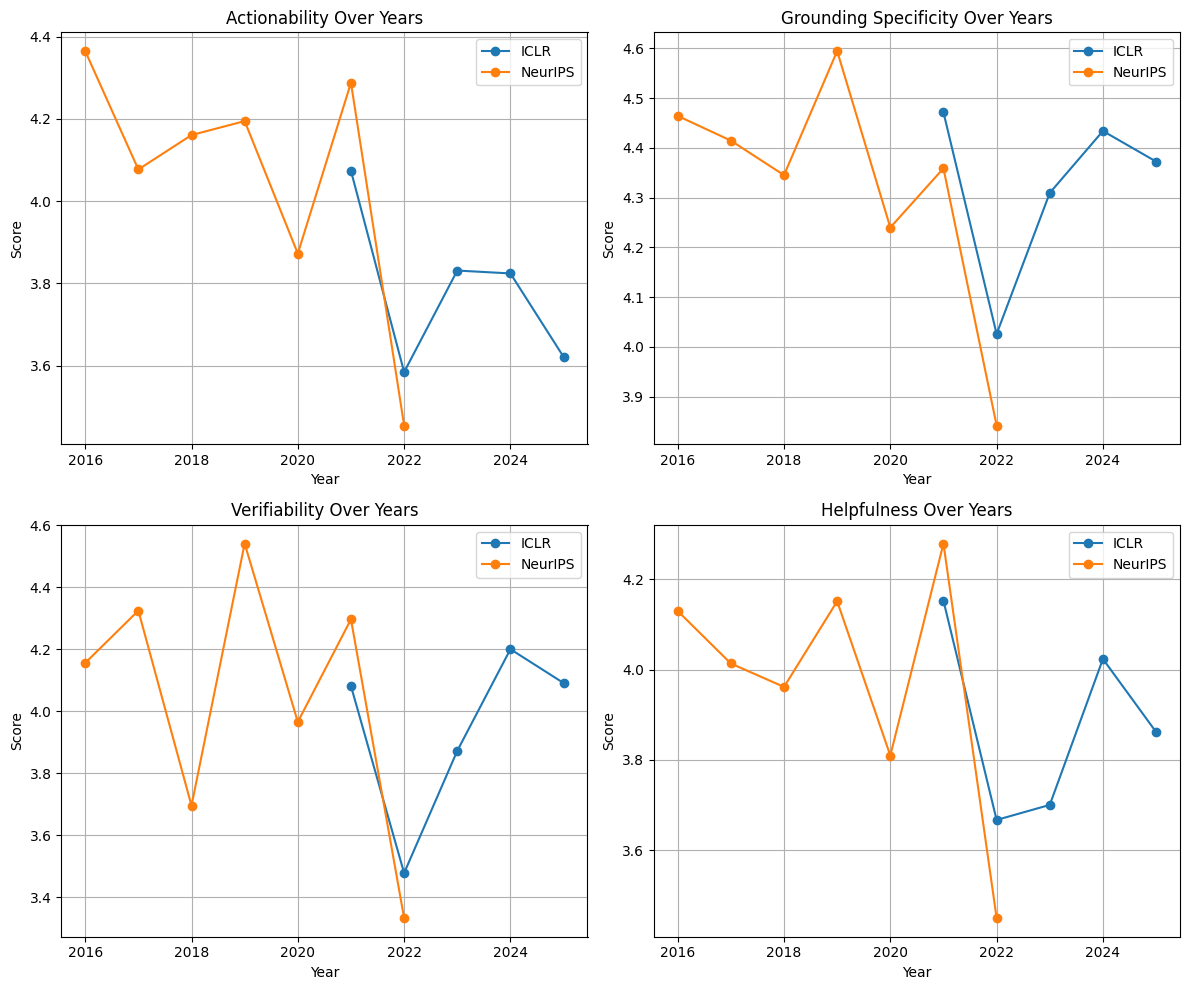

In [5]:
import matplotlib.pyplot as plt

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Filter data to include only ICLR and NIPS (renamed to NeurIPS)
filtered_data = {}
for aspect_key, venues_scores in aspect_dict.items():
    aspect_name = aspect_key.replace('_mean', '')
    filtered_data[aspect_name] = {}
    for venue_year, score in venues_scores.items():
        venue, year = venue_year.rsplit('_', 1)
        year = int(year)
        if venue in ['ICLR', 'NIPS']:
            if venue == 'NIPS':
                venue = 'NeurIPS'  # Rename NIPS to NeurIPS
            if venue not in filtered_data[aspect_name]:
                filtered_data[aspect_name][venue] = {}
            filtered_data[aspect_name][venue][year] = score

# Plotting each aspect
for idx, (aspect, venues_data) in enumerate(filtered_data.items()):
    ax = axes[idx]
    for venue, year_score in venues_data.items():
        years = sorted(year_score.keys())
        scores = [year_score[year] for year in years]
        ax.plot(years, scores, marker='o', label=venue)
    ax.set_title(f"{aspect.replace('_', ' ').title()} Over Years")
    ax.set_xlabel("Year")
    ax.set_ylabel("Score")
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("outputs/qulity_over_years.pdf", format="pdf")
plt.show()
